In [ ]:
!pip3 install shap

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import shap
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Чтение данных
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

# Удаляем строки с пропусками
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [ ]:
# Разделим данные на признаки и целевую переменную (id не нужен)
X_train = train_data.drop(columns=["ID", "class"])
y_train = train_data["class"]
X_test = test_data.drop(columns=["ID"])

In [ ]:
# Преобразуем категориальные переменные в фиктивные
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# Нормализуем числовые признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Разделим тренировочные данные на обучающую и валидационную выборки для графиков обучения
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)


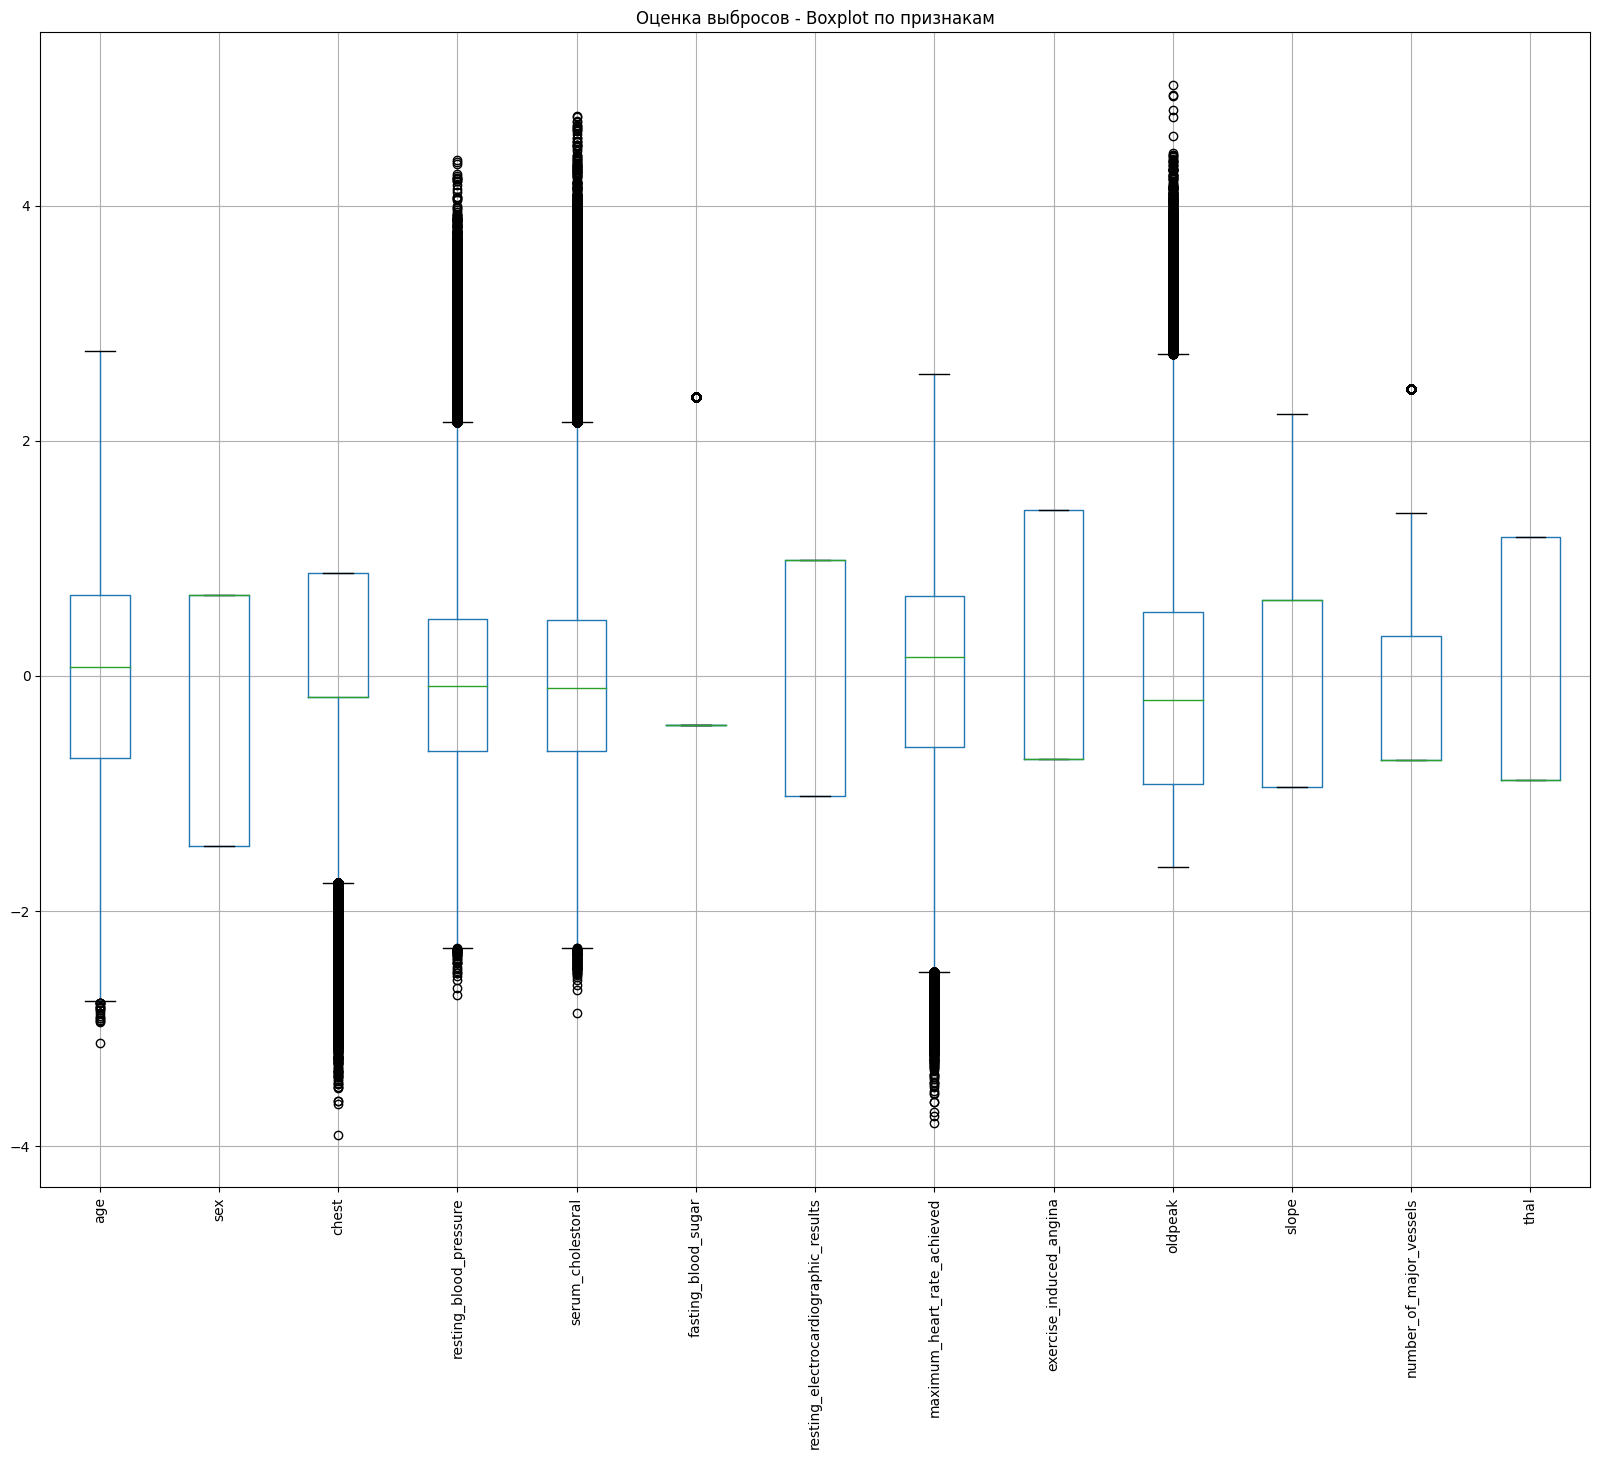

In [ ]:
# 1. Построение диаграммы выбросов (Boxplot)
plt.figure(figsize=(20, 15))
X_train_df = pd.DataFrame(X_train_split, columns=X_train.columns)
X_train_df.boxplot()
plt.xticks(rotation=90)
plt.title("Оценка выбросов - Boxplot по признакам")
plt.show()

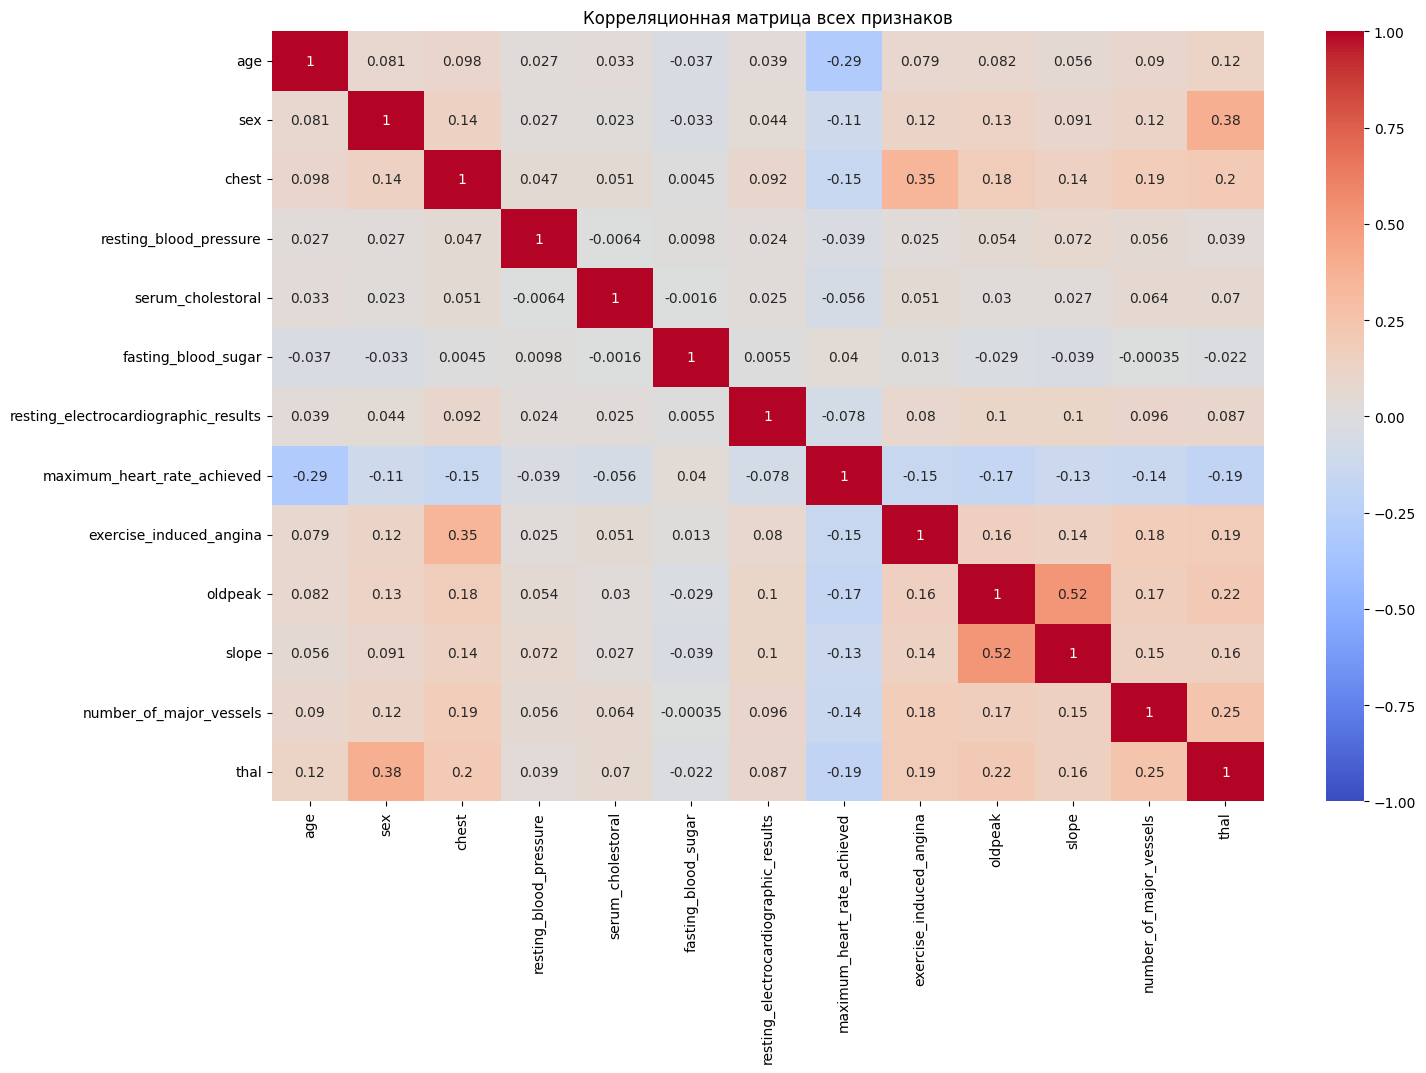

In [ ]:
# Корреляционная матрица (строим на уменьшенном подмножестве данных)
corr_subset = pd.DataFrame(X_train_split, columns=X_train.columns).sample(n=5000, random_state=42)
corr_matrix = corr_subset.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)  # Добавлены подписи значений
plt.title("Корреляционная матрица всех признаков")
plt.show()

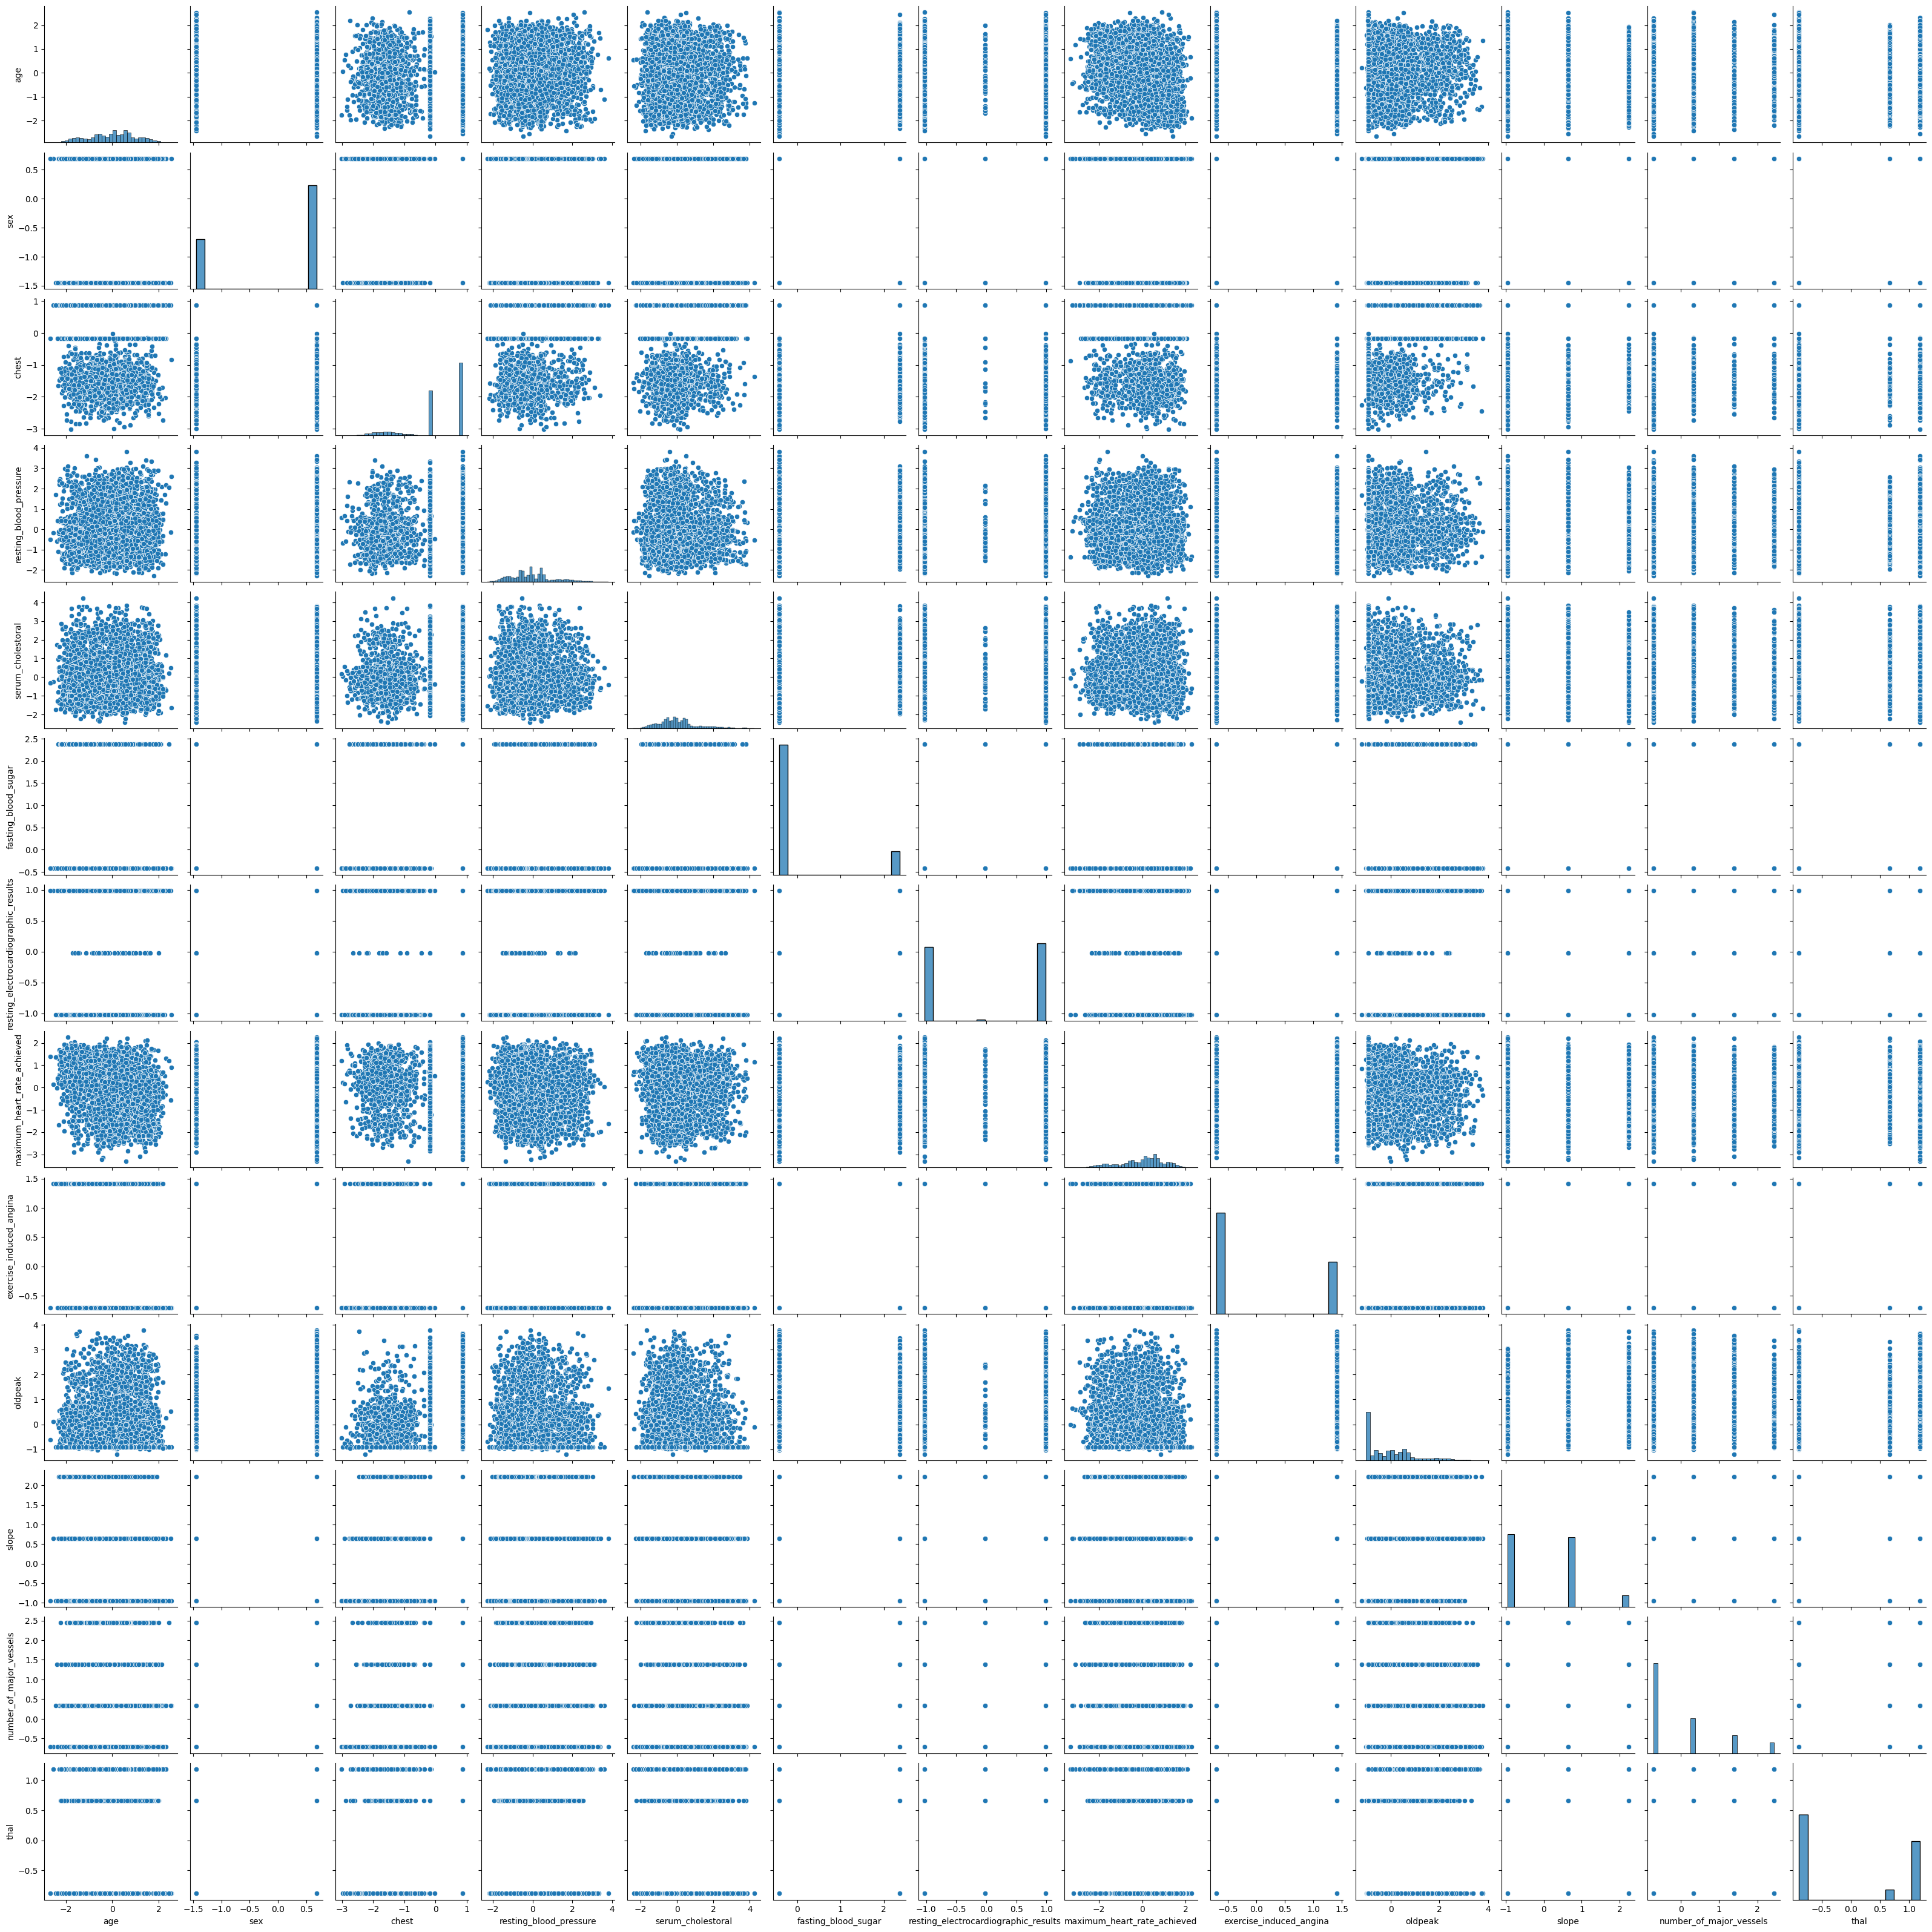

In [ ]:
# 3. Диаграмма рассеяния для всех признаков
sns.pairplot(pd.DataFrame(X_train_split, columns=X_train.columns).sample(5000, random_state=42))
plt.show()

Подбор гиперпараметров для модели: Logistic Regression
Лучшая точность на валидационных данных для Logistic Regression: 0.87825
Лучшие гиперпараметры для Logistic Regression: {'C': 1, 'solver': 'liblinear'}


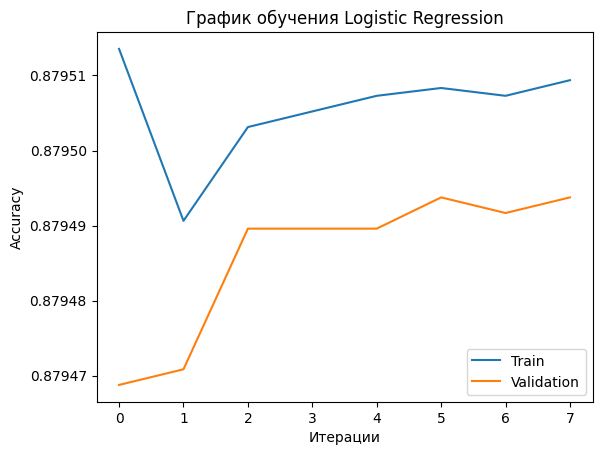

Подбор гиперпараметров для модели: Random Forest
Лучшая точность на валидационных данных для Random Forest: 0.8974916666666667
Лучшие гиперпараметры для Random Forest: {'max_depth': 15, 'n_estimators': 50}


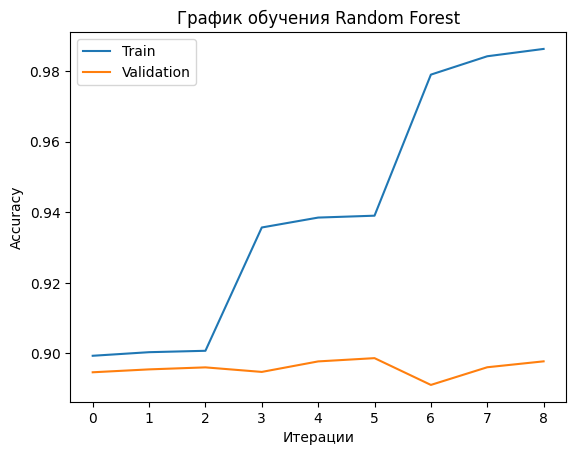

Подбор гиперпараметров для модели: Neural Network
Лучшая точность на валидационных данных для Neural Network: 0.897575
Лучшие гиперпараметры для Neural Network: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.01}


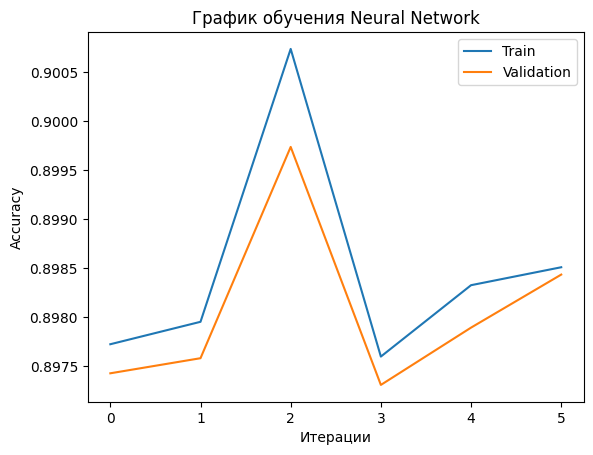

In [ ]:
# Обучение моделей в цикле с подбором гиперпараметров и графиками обучения
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=500),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ['lbfgs', 'liblinear']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10, 25, 50],
            "max_depth": [10, 15, 20]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(max_iter=100),
        "params": {
            "hidden_layer_sizes": [(30,), (50,), (50, 30)],
            "alpha": [0.0001, 0.001],
            "learning_rate": ['constant'],
            "learning_rate_init": [0.01]
        }
    }
}
best_model = None
best_accuracy = 0
best_params = {}

for name, config in models.items():
    print(f"Подбор гиперпараметров для модели: {name}")

    grid = GridSearchCV(config["model"], config["params"], cv=3, return_train_score=True)
    grid.fit(X_train_split, y_train_split)
     # Оценка на валидационной выборке
    y_val_pred = grid.predict(X_val_split)
    accuracy = accuracy_score(y_val_split, y_val_pred)

    print(f"Лучшая точность на валидационных данных для {name}: {accuracy}")
    print(f"Лучшие гиперпараметры для {name}: {grid.best_params_}")

    # Определяем лучшую модель
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    # График обучения (используем средние значения из кросс-валидации)
    train_scores_mean = grid.cv_results_['mean_train_score']
    test_scores_mean = grid.cv_results_['mean_test_score']
    plt.plot(train_scores_mean, label="Train")
    plt.plot(test_scores_mean, label="Validation")
    plt.title(f"График обучения {name}")
    plt.xlabel("Итерации")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Тестирование лучшей модели на тестовых данных
print(f"Лучшая модель: {best_model} с точностью: {best_accuracy}")
print(f"Лучшие гиперпараметры для лучшей модели: {best_params}")
y_test_pred = best_model.predict(X_test_scaled)

# Вывод первых 50 предсказаний на тестовых данных вместе с исходными записями
print("Предсказания на тестовых данных для первых 50 записей:")
for i in range(50):
    print(f"Запись {X_test.iloc[i].to_dict()} -> Предсказание: {y_test_pred[i]}")

Лучшая модель: MLPClassifier(hidden_layer_sizes=(50, 30), learning_rate_init=0.01,
              max_iter=100) с точностью: 0.897575
Лучшие гиперпараметры для лучшей модели: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
Предсказания на тестовых данных для первых 50 записей:
Запись {'age': 53.963191, 'sex': 1.0, 'chest': 4.0, 'resting_blood_pressure': 136.940829, 'serum_cholestoral': 236.862814, 'fasting_blood_sugar': 0.0, 'resting_electrocardiographic_results': 2.0, 'maximum_heart_rate_achieved': 143.961525, 'exercise_induced_angina': 1.0, 'oldpeak': 0.7111, 'slope': 1.0, 'number_of_major_vessels': 2.0, 'thal': 7.0} -> Предсказание: 1
Запись {'age': 49.621479, 'sex': 1.0, 'chest': 4.0, 'resting_blood_pressure': 122.024651, 'serum_cholestoral': 226.593019, 'fasting_blood_sugar': 0.0, 'resting_electrocardiographic_results': 2.0, 'maximum_heart_rate_achieved': 112.220874, 'exercise_induced_angina': 1.0, 'oldpeak': 0.0, 'slope': 

  0%|          | 0/100 [00:00<?, ?it/s]

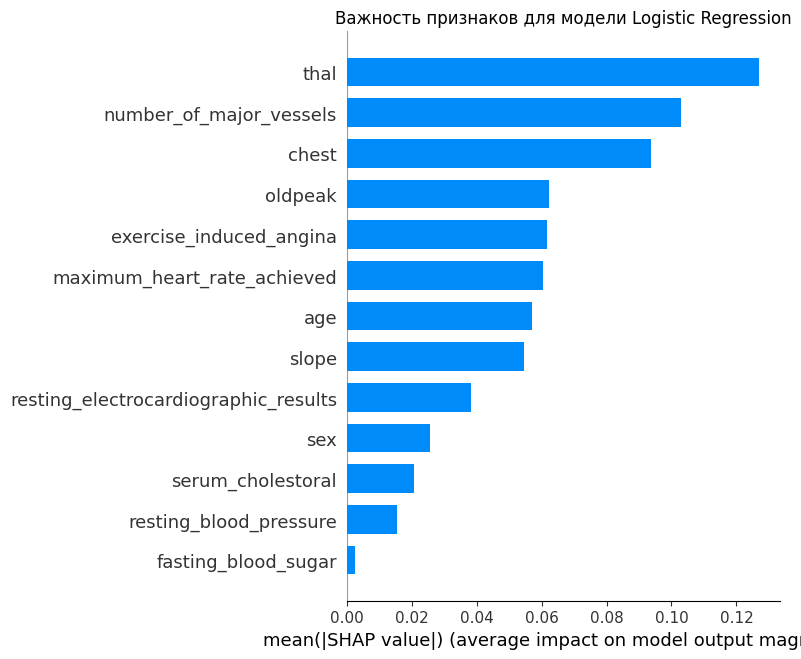

  0%|          | 0/100 [00:00<?, ?it/s]

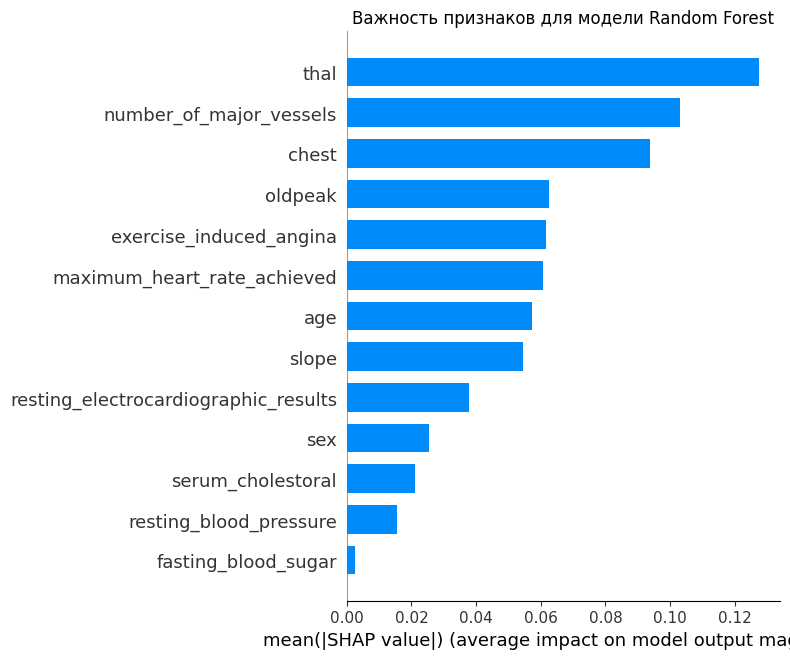

  0%|          | 0/100 [00:00<?, ?it/s]

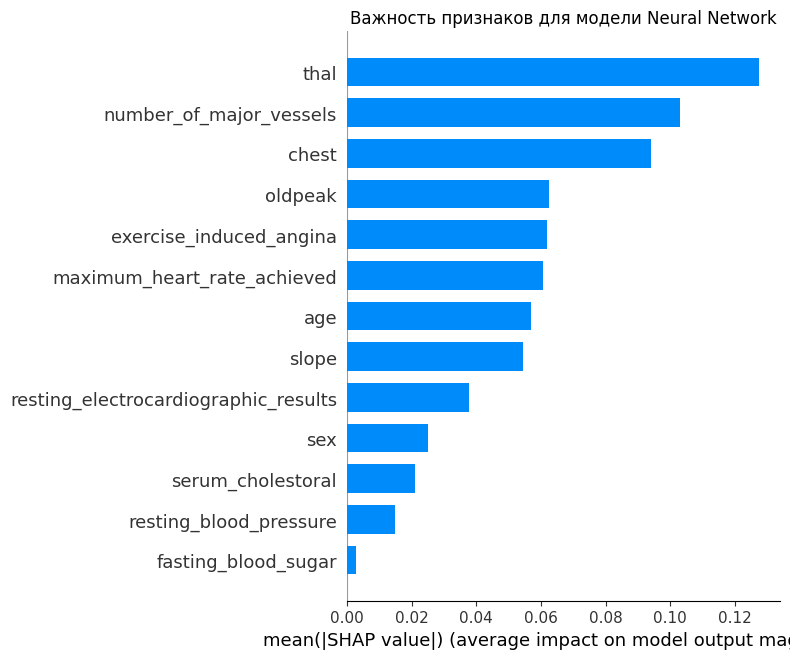

In [ ]:
# Визуализация важности признаков для каждой модели
def plot_feature_importance(model, model_name, X_train):
    # Для моделей, поддерживающих feature_importances_ (например, RandomForest)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
        plt.title(f"Важность признаков для модели {model_name}")
        plt.show()

    # Для линейных моделей (например, Logistic Regression)
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        feature_importance_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
        plt.title(f"Важность признаков для модели {model_name}")
        plt.show()

    # Для других моделей можно использовать SHAP
    else:
        try:
            # Ограничиваем фоновые данные для SHAP
            background_sample = X_train.sample(n=100, random_state=42)  # 1000 записей для фона
            explainer = shap.KernelExplainer(model.predict, background_sample)

            shap_values = explainer.shap_values(background_sample)

            plt.title(f"Важность признаков для модели {model_name}")
            shap.summary_plot(shap_values, background_sample, plot_type="bar")
            plt.show()
        except Exception as e:
            print(f"Модель {model_name} не поддерживает вывод важности признаков напрямую и возникла ошибка: {e}")

# Важность признаков для каждой модели
for name, config in models.items():
    model = config["model"]
    plot_feature_importance(best_model, name, pd.DataFrame(X_train_split, columns=X_train.columns))

In [ ]:
#Подготовим скрипт для запуска инференса
import joblib

# Сохраняем лучшую модель на Google Диск
best_model_file = '/content/drive/MyDrive/best_model.pkl'
joblib.dump(best_model, best_model_file)
print(f"Лучшая модель сохранена в {best_model_file}")

scaler_file = '/content/drive/MyDrive/scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"Scaler сохранен в {scaler_file}")

Лучшая модель сохранена в /content/drive/MyDrive/best_model.pkl
Scaler сохранен в /content/drive/MyDrive/scaler.pkl


In [ ]:

# Загрузка модели и scaler с Google Диска
model_file = '/content/drive/MyDrive/best_model.pkl'
scaler_file = '/content/drive/MyDrive/scaler.pkl'

best_model = joblib.load(model_file)
scaler = joblib.load(scaler_file)

print(f"Модель {best_model} и Scaler успешно загружены.")

# Пример кода для инференса (чтение данных, предобработка и предсказание)
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")  # путь к тестовым данным на Google Диске

# Удаляем строки с пропусками
test_data.dropna(inplace=True)

# Преобразуем признаки
X_test = test_data.drop(columns=["ID"])
X_test = pd.get_dummies(X_test, drop_first=True)

# Масштабируем данные
X_test_scaled = scaler.transform(X_test)

# Предсказания
y_test_pred = best_model.predict(X_test_scaled)

# Вывод первых 50 предсказаний
print("Предсказания для первых 50 записей:")
for i in range(50):
    print(f"Запись {X_test.iloc[i].to_dict()} -> Предсказание: {y_test_pred[i]}")

# Сохранение предсказаний на Google Диск
output_file = '/content/drive/MyDrive/test_predictions.csv'
output_df = pd.DataFrame({'id': test_data['ID'], 'predictions': y_test_pred})
output_df.to_csv(output_file, index=False)
print(f"Предсказания сохранены в файл {output_file}")

Модель MLPClassifier(hidden_layer_sizes=(50, 30), learning_rate_init=0.01,
              max_iter=100) и Scaler успешно загружены.
Предсказания для первых 50 записей:
Запись {'age': 53.963191, 'sex': 1.0, 'chest': 4.0, 'resting_blood_pressure': 136.940829, 'serum_cholestoral': 236.862814, 'fasting_blood_sugar': 0.0, 'resting_electrocardiographic_results': 2.0, 'maximum_heart_rate_achieved': 143.961525, 'exercise_induced_angina': 1.0, 'oldpeak': 0.7111, 'slope': 1.0, 'number_of_major_vessels': 2.0, 'thal': 7.0} -> Предсказание: 1
Запись {'age': 49.621479, 'sex': 1.0, 'chest': 4.0, 'resting_blood_pressure': 122.024651, 'serum_cholestoral': 226.593019, 'fasting_blood_sugar': 0.0, 'resting_electrocardiographic_results': 2.0, 'maximum_heart_rate_achieved': 112.220874, 'exercise_induced_angina': 1.0, 'oldpeak': 0.0, 'slope': 1.0, 'number_of_major_vessels': 1.0, 'thal': 7.0} -> Предсказание: 1
Запись {'age': 36.933893, 'sex': 1.0, 'chest': 1.300924, 'resting_blood_pressure': 127.585643, 'seru

**1. Цель исследования**

Построение моделей машинного обучения для прогнозирования наличия у пациента ССЗ на основе предоставленных данных.

**2. Детализация задач**

*   Анализ и предобработка данных.
*   Обучение моделей (Logistic Regression, Randomforest, Neural Network) и сравнение результатов. Построение графиков зависимостей, выбросов.
*   Проверка состоятельности и валидация модели на тестовых данных.
*   Подготовка скрипта для инференса.

**3. Технологии**

В ходе работы мы использовали следующие библиотеки и технологии:

* Pandas для работы с данными.
* NumPy для операций с массивами.
* Matplotlib и Seaborn для визуализации данных.
* Scikit-learn для предобработки данных, построения моделей и подбора гиперпараметров.
* SHAP для анализа важности признаков.
* joblib для сохранения и загрузки модели.

**4. Основные пункты работы**

1. Предобработка данных:
  * Удаление строк с пропусками, чтобы избежать ошибок в обучении моделей.
  * Преобразование категориальных признаков с использованием фиктивных переменных (one-hot encoding).
  * Масштабирование числовых признаков с использованием стандартизации, что улучшает сходимость некоторых моделей.

2.  Анализ данных:
  * Построение корреляционной матрицы для выявления взаимосвязей между признаками. Она показала, какие признаки имеют сильную положительную или отрицательную корреляцию между собой.
  * Построение диаграммы рассеяния для визуализации распределения данных и возможных закономерностей между различными признаками.
  * Построение графиков выбросов. Они помогли выявить выбросы в данных и оценить распределение значений признаков.

3. Построение и обучение моделей:
  * Мы обучили три модели: логистическую регрессию, случайный лес, нейронную сеть.
  * Для каждой модели был выполнен подбор гиперпараметров с помощью GridSearchCV, что позволило улучшить точность предсказаний.
  * По результатам валидации мы выбрали наилучшую модель с точки зрения точности.

4. Оценка и визуализация результатов:
  * Для каждой модели были выведены наилучшие гиперпараметры, что позволило детально оценить, какие параметры влияют на качество предсказаний.
  * Графики обучения были построены для всех моделей, что помогло понять динамику изменения ошибки на этапе обучения и избежать переобучения.
  * Важность признаков была визуализирована для каждой модели. Для моделей, где невозможно было получить важность напрямую, использовалась библиотека SHAP, которая показала, какие признаки сильнее всего влияют на предсказания.

5. Результаты анализа:
  * По результатам анализа важности признаков, с использованием случайного леса и SHAP, можно сделать выводы о том, какие признаки имеют наибольшее влияние на прогнозирование заболевания. Некоторые признаки, такие как физиологические показатели (например, уровень давления, индекс массы тела и др.), имели высокий уровень значимости. Признаки, связанные с полом, возрастом и определенными медицинскими обследованиями, также оказались важными.
  * Наиболее значимые признаки могут варьироваться в зависимости от модели, однако совпадения среди ключевых признаков могут указывать на их высокую значимость.
  * Анализ корреляционной матрицы показал, что некоторые признаки имеют умеренную корреляцию друг с другом, что может указывать на наличие латентных зависимостей. Например, уровень физической активности мог коррелировать с индексом массы тела и состоянием сердечно-сосудистой системы.
  * Подбор гиперпараметров показал, что точность моделей значительно зависит от их настройки. Например:

    * В логистической регрессии ключевыми параметрами были значение регуляризации и тип оптимизатора.

    * В случайном лесе наибольшее влияние оказали количество деревьев и глубина дерева.

    * В нейронной сети важную роль играла структура слоев и скорость обучения.

**5. Заключение**
* В результате работы мы построили несколько моделей машинного обучения, каждая из которых прошла подбор гиперпараметров. На основе валидации была выбрана лучшая модель, которая показала наилучшую точность при прогнозировании заболевания. Мы также выявили наиболее значимые признаки, влияющие на прогноз, что может помочь в дальнейшем медицинском анализе и принятии решений.